<a href="https://colab.research.google.com/github/hmgu-itg/VolosSummerSchool/blob/master/VSS_2023/7_Workshop_molQTL/VSS_QTL_practical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QTL practical
*(Alexandros Simistiras, simistiras@fleming.gr)*

-   In this workshop, we will familiarize ourselves with the basic implementation of QTL mapping. For the purposes of this practical we will use genotype and Gene expression data in human individuals.

-   **Note!** The data have already passed the necessary QC (Quality Control checks e.g.normalization) and are ready to be analysed.

*First we have to install several packages...*

In [ ]:
# Install all the necessarry packages.
install.packages('dplyr')
install.packages('tidyr')
install.packages('ggplot2')
#install.packages('factoextra')
#if (!requireNamespace('devtools', quietly = TRUE))
#install.packages('devtools')
#devtools::install_github('kevinblighe/PCAtools')
install.packages('IRdisplay')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# Load the libraries.
library(dplyr)
library(tidyr)
library(ggplot2)
#library(PCAtools)
library(IRdisplay)

In [ ]:
# Unzip the Data & dependencies.
system('unzip Data_and_dependencies.zip', intern = T)

system('ls', intern = T)


- A quick overview of the things we are going to cover.

[1] "/content/Data_and_dependencies"

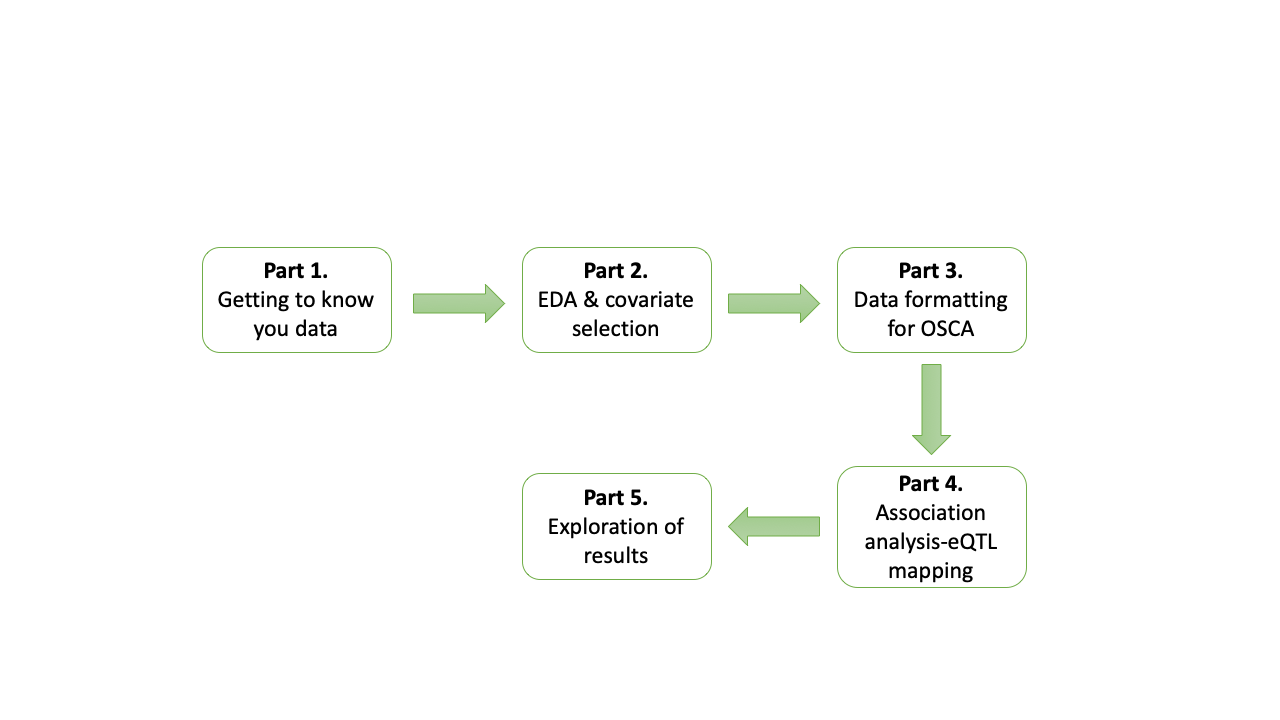

In [ ]:
setwd('Data_and_dependencies') # Set the working directory
getwd()

display_png(file = 'workflow.png')

---
### Part 1. Getting to know your data

-   First, we are going to load all the necessary files:
  - What we need :
      - a.  Genotypes
      - b.  Gene Expression data
      - c.  Info for Genes and SNPs (position, chromosome etc.)

In [ ]:
# a.
snps = read.table('input/uniq.snps.txt', header = T) # Genotype info - it has been converted to Allele matrix.

snps |> select(snp, everything())->snps # Re-arrange the columns.
temp = separate(snps, snp, into = c('chr', 'pos', 'A1', 'A2'), sep = '_')
temp$snp = paste(temp$chr, temp$pos, temp$A1, temp$A2, sep = '_')
snps$snp = temp$snp

rm(temp)
head(snps)


In [ ]:
# b.
ge = read.table('input/ge.profile.txt', header = T) # Gene expression data (RPKM values).
head(ge)

In [ ]:
# c.
snp.loc = read.table('input/snps.loc.txt', header = T) # Location info for SNPs.
head(snp.loc)
gene.loc = read.table('input/gene.loc.txt', header = T) # Location info for Genes.
head(gene.loc)

---
#### Questions Part 1.

  1.  How many Samples, SNPs and Genes do we have ?
  2.  On which chromosome are the SNPs and Genes located ?

In [ ]:
# 1. TYPE YOUR RESPONSE HERE

In [ ]:
#@title
# 1. How many Samples, SNPs and Genes do we have?
cat('Number of Genes:', ncol(ge)-1, '\n' );
cat('Number of samples:', ncol(snps)-1, '\n');
cat('Number of SNPs:', nrow(snps), '\n')

In [ ]:
# 2. TYPE YOUR RESPONSE HERE

In [ ]:
#@title
# 2. On which chromosome are the SNPs and Genes located ?
cat('Chromosome of SNPs:', unique(snp.loc$chr), '\n')
cat('Chromosome of Genes:', unique(gene.loc$chr), '\n')

---
### Part 2. EDA and covariate selection

- Although the data have passed the necessary QC steps, we will check for  outlying individuals/observations for both Genotype and GE data.
A common practice to do this -in high dimensional data- is via Principal Component Analysis (PCA).

*-Outlying observations can inflate false positive findings.*

- We will start with the PCA of genotypes. After computing the Principal Components (PCs) we are going to plot the first two of them.

*-By definition the first PC captures the majority of variance in the variables of interest.*

In [ ]:
# PCA in genotypes via prcomp in R.
temp = t(snps[,-1]) # Also we have to transpose the data frame since the package stores the variables as columns and subjects as rows !
geno.pca <- prcomp(temp, scale. = T) # Remember to include only the continuous variables.
summary(geno.pca) # Take a look at the output of the first 5 PCs

# Visual inspection of PCs, plotting the first 2 PCs.
pca.data <-  data.frame(PC1=geno.pca$x[,1], PC2=geno.pca$x[,2])

cat('', '\n')
PC1.sd <-  sd(pca.data$PC1)
PC2.sd <-  sd(pca.data$PC2)

ggplot(data=pca.data, aes(x=PC1, y=PC2)) +
  geom_point() +
  geom_vline(xintercept = mean(pca.data$PC1) - 3*PC1.sd, colour="red", linetype = "longdash") +
  geom_vline(xintercept = mean(pca.data$PC1) + 3*PC1.sd, colour="red", linetype = "longdash") +
  geom_hline(yintercept = mean(pca.data$PC2) - 3*PC2.sd, colour="blue", linetype = "longdash") +
  geom_hline(yintercept = mean(pca.data$PC2) + 3*PC2.sd, colour="blue", linetype = "longdash") +
  ggtitle('PCA for Genotype data')

rm(temp)

- The points in the scatter plot are randomly scattered, no indication of clustering.

Next, we are going to produce the same plot for the GE data...

In [ ]:
# The same procedure as above.
ge.pca = prcomp(ge[,-1], scale = T) # No need to transpose the data frame.

# PCA data.frame
pca.data = data.frame(PC1=ge.pca$x[,1], PC2=ge.pca$x[,2])

PC1.sd = sd(pca.data$PC1)
PC2.sd = sd(pca.data$PC2)

# Visual inspection of PCs.
ggplot(data=pca.data, aes(x=PC1, y=PC2)) +
  geom_point() +
  geom_vline(xintercept = mean(pca.data$PC1) - 3*PC1.sd, colour="red", linetype = "longdash") +
  geom_vline(xintercept = mean(pca.data$PC1) + 3*PC1.sd, colour="red", linetype = "longdash") +
  geom_hline(yintercept = mean(pca.data$PC2) - 3*PC2.sd, colour="blue", linetype = "longdash") +
  geom_hline(yintercept = mean(pca.data$PC2) + 3*PC2.sd, colour="blue", linetype = "longdash") +
  ggtitle('PCA for GE data')

# Variation explained for each PC.
pca.object.var = ge.pca$sdev^2 # variance
pca.object.var  = round(pca.object.var/sum(pca.object.var)*100, 1) # percentage of explained variance
barplot(pca.object.var.per[1:10], main="Percent variation for PC1-10",
        xlab = "PC",
        ylab = "Percent Variation (%)",
        xlim = c(0, 11),
        ylim = c(0,100))

rm(pca.object.var, pca.object.var.per)

#### Questions Part 2.

  1. What do you think of the PCA plot in GE data ? Any outliers ?
  2. How much variation do the first 3 components explain in GE data ?


In [ ]:
#@title
#.1 TYPE YOUR RESPONSE HERE

# As we can see there is one point that falls outside the bondaries but it is still very close in one of them.
# Even if we are going to exclude this observation it is unlikely that this will influence the behaviour of the other points.

In [ ]:
#.2 TYPE YOUR RESPONSE HERE

In [ ]:
#@title
# 2. How much variation the first 3 components explain in GE data ?
round(sum(ge.pca$sdev[1]^2, ge.pca$sdev[2]^2, ge.pca$sdev[3]^2)/sum(pca.object.var)*100, 3)

summary(ge.pca) # Check it.

- Except of outlying detection, PCA, can also be used for covariate selection.

*-Recall from the previous lectures that when we are modelling the effect of a variable in an outcome of interest, in our case the genetic effect of SNP in GE, we have to control for additional factors that may confound the relationship that we are investigating.*

- We hold data for Age, Sex and BMI for each participant, go ahead and load the data.

In [ ]:
# Load the factors/covariates.
age = read.table('input/Age.txt', header = F)
age = age[,c(1,3)] # Drop the duplicated column.
colnames(age) <- c('IID','age')

sex = read.table('input/Sex.txt', header = F)
sex = sex[,c(1,3)] # Drop the duplicated column.
colnames(sex) <- c('IID','sex')

bmi = read.table('input/BMI.txt', header = F)
bmi = bmi[,c(1,3)] # Drop the duplicated column.
colnames(bmi) <- c('IID','bmi')

- Since we have high dimensional data i.e. 2145 GE values for
each participant we cannot make pairwise correlations for each Gene and factor, thus we use dimension reduction techniques like PCA.

In [ ]:
# Correlation plot of PCs with covariates
display_png(file = 'cor.plot.pearson.png')

# Do the the PCs of GE correlate with the observed covariates/factors ?
#metadata = merge(age, sex, by = 'IID')
#metadata = merge(metadata, bmi, by = 'IID')

#ge$IID%in%metadata$IID # Sanity check.

#matching.ind <- ge$IID # Make sure that we have the same order in SampleIDs between dataframes.

#metadata <- metadata[match(matching.ind, metadata$IID),] # Tricky the first argument of match defines the order of matching values.

#identical(ge$IID, metadata$IID) # Sanity check.

# Data manipulation to meet the need of PCAtools.
#t.ge <- t(as.matrix(ge))
#colnames(t.ge) <- t.ge[1,]
#t.ge <- t.ge[-1,]
#rownames(t.ge) <- NULL
#t.ge <- data.frame(t.ge)
#t.ge[,] <- sapply(t.ge, as.numeric)

#rownames(metadata) <- metadata$IID

#p <- pca(t.ge, metadata = metadata) # Make the PCA object.

#eigencorplot(p, metavars = c('age','bmi','sex')) # Correlation matrix.

- No indication of strong correlations.

---
### Part 3. Data formatting for OSCA.

OSCA (OmicS-data-based Complex trait Analysis) is a tool written in C++ and it is specialized for genetic association analyses with molecular traits (Gene Expression data, Metabolites etc.). It is developed by YangLab more info at (https://yanglab.westlake.edu.cn/software/osca/#eQTL/mQTLAnalysis)


In this section we are going to prepare the input files for OSCA

  - OSCA stores the input data in a similar way to plink (see below).

In [ ]:
# BOD file
display_png(file = 'bod.format.png')

- In order to make a bod files we simply have to provide the Gene expression (or any other molecuar trait) data with **individuals in rows** and **traits in columns**.

In [ ]:
# Make bod file
system('./osca-0.46.1 --efile input/ge.profile.txt --gene-expression --make-bod --no-fid --out output/ge.profile2')

# Inspect the output files: .opi (gene-info), .oii (individual info)
oii = read.table('output/ge.profile2.oii')
opi = read.table('output/ge.profile2.opi')
head(opi)
head(oii)

- As you can see we are missing some info in the .opi file.
- Update the .opi file to add info for the gene TSS etc.

In [ ]:
# Update .opi file to store extra information for genes - chr,TSS etc.
system('./osca-0.46.1 --befile output/ge.profile2 --update-opi input/ge.opi')

opi = read.table('output/ge.profile2.opi')
head(opi)



- We are good to go!
---
### Part 4. Association analysis - QTL mapping
- We are going to perform a cis-association analysis on chromosome1. That is, only the variants that fall inside a 2Mb window from the TSS of the gene of interest are going to be included in the association model.

  - Recall that we are using a linear regression model to estimate the genetic effect of each variant in the expression of each Gene.

! **Before we proceed**, we will calculate the PCs of genotypes to account for the genetic relatedness between participants.

 - Calculate using plink the first three PCs of genotypes to account for the genetic relationship between individuals.

In [ ]:
# Eigen vectors of genotypes.
system('cd plink_linux/ ; ./plink --bfile /content/Data_and_dependencies/input/fake.uniq.genotypes.chr --pca 3 --out /content/Data_and_dependencies/output/geno.pcs')

system('cd output ; head geno.pcs.eigenvec', intern = T)

- Include in the model as covariates the BMI and the 3 first PCs of genotypes.

  - To do that, OSCA just as plink, accepts the nominal variables as **--covar** and the continuous as **--qcovar**.

  - *Check the syntax of the command below.*



In [ ]:
# Run the analysis
system('./osca-0.46.1 --eqtl --bfile input/fake.uniq.genotypes.chr --befile output/ge.profile2 --qcovar input/BMI.txt --qcovar output/geno.pcs.eigenvec --cis --cis-wind 1000 --thread-num 10 --out output/cis.eqtls.chr1', intern = T)

system('cat output/cis.eqtls.chr1_1_1.log', intern = T)

- OSCA stores all the summary statistics in a file with **.besd** extension.

- To retrieve the results we can query through the **.besd** file with the option of **query** and filter the results e.g. according to p-values.

- For the needs of the current practical we are going to call significant eQTLs at $5e^{-8}$ p-value threshold.

---
#### Questions Part 5.

  1. How many tests did we perform ?
  2. How many eGenes (Genes with at least one sig. SNP) and eQTLs do we have ?
  3. Retrieve the best eQTL per Gene.

In [ ]:
#.1 TYPE YOUR RESPONSE HERE

In [ ]:
#@title
# 1.
cat('Number of cis-tests: ', system('cd output/ ; cat *.besd | wc -l', intern = T), '\n')


- Use the command below to extract the sig. eQTLs from the .besd file.

In [ ]:
# 2.
# Query the .besd file (summartized results) to extract the eqtls at the specified threshold.
system('./osca-0.46.1 --beqtl-summary output/cis.eqtls.chr1  --query 5e-8 --out output/eqtls.5e-8.txt')

In [ ]:
#.2 TYPE YOUR RESPONSE HERE

In [ ]:
#@title
# 2.
eqtls <- read.table('output/eqtls.5e-8.txt', header = T)
cat('Number of eGenes : ', length(unique(eqtls$Gene)), '\n')
cat('Number of eqtls : ', nrow(eqtls))

In [ ]:
#.3 TYPE YOUR RESPONSE HERE

In [ ]:
#@title
# 3.
eqtls %>%
  group_by(Gene) %>%
  slice(which.min(p))

---
# Further exploration


- Next, make a histogram for the distance of cis-eQTLs from the TSS of the canditate Gene.

In [ ]:
# Distance to TSS.
eqtls$dist.to.tss = eqtls$BP-eqtls$Probe_bp

hist(eqtls$dist.to.tss, breaks = 100, main = 'Histogram of cis-eQTL distances ' , xlab = 'Distance to TSS')
abline(v=0)


- As we expected most of the signals are clustereed around the TSS of the Gene.


Now, let's retrieve the best eQTL (the one with the smallest p-value) for the eGene with the most findings.

In [ ]:
# Best eQTL for the Gene with the Gene with most findings.
eqtls |> group_by(Gene) |> summarise(n.eqtls = n()) |> arrange(desc(n.eqtls))

eqtls |> filter(Gene == 'ENSG00000236624.4') |>  slice(which.min(p))->top.signal

- Visualize the effect of the best eQTL for the ENSG00000236624.4 Gene.

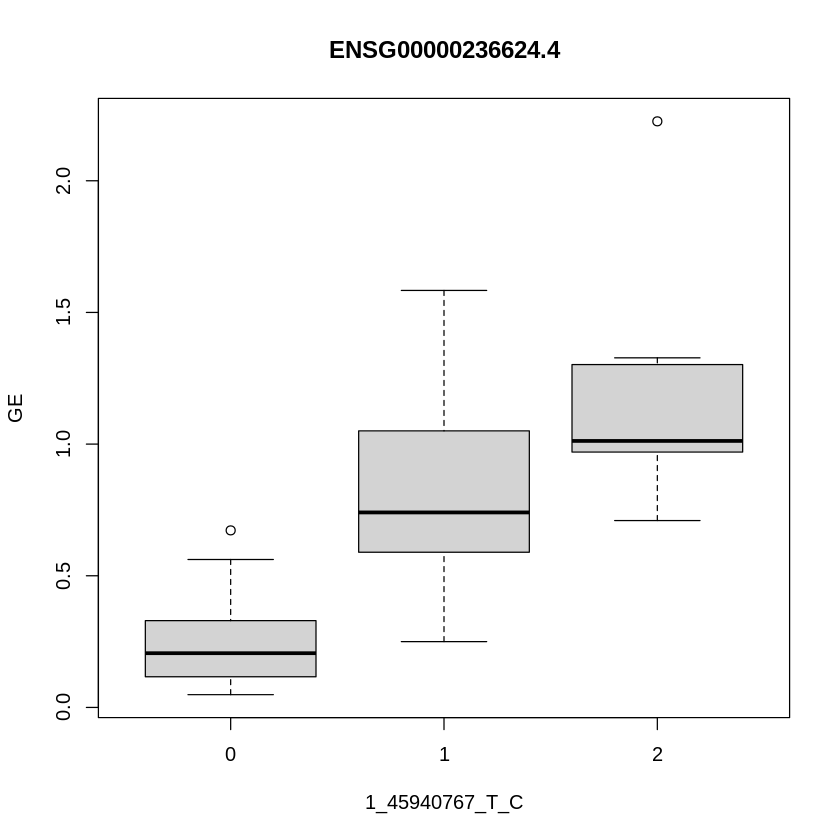

In [ ]:
# Boxplot for the best eQTL.
snps |> filter(snp == top.signal$SNP)->plot.data

temp = as.data.frame(t(plot.data))
temp$iid = rownames(temp)
colnames(temp) = temp[1,]
temp = temp[-1,]
ge.top.signal = ge[, c('IID',top.signal$Gene)]

merged = merge(temp, ge.top.signal, by.x = 'snp', by.y = 'IID')

boxplot(merged$`ENSG00000236624.4` ~ as.factor(merged$`1_45940767_T_C`), xlab = "1_45940767_T_C",
   ylab = "GE", main = "ENSG00000236624.4")

---
